# NLP Task 3 

### Code adapted from https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894#ec34

Dataset based from https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from collections import defaultdict

In [2]:
# load data from csv 
df = pd.read_csv('FinalDatasetwithpeprosing.csv')

# Remove rows with NaN values in 'content' and 'sentiment' columns
df = df.dropna(subset=['content', 'sentiment'])

# Convert sentiment to numeric with label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

text = df.content.values
labels = df.sentiment.values



In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [6]:
token_id = []
attention_masks = []

# Preprocess the text
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

# Iterate over the dataset to encode each sentence
for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

# Convert lists to tensors
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
# Set a seed value
seed_value = 42  
torch.manual_seed(seed_value)
np.random.seed(seed_value)

In [8]:
from sklearn.model_selection import train_test_split


batch_size = 16


# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure the ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

# First split: 70% train, 30% temp
train_idx, temp_idx = train_test_split(
    np.arange(len(labels)),
    test_size = 1 - train_ratio,
    shuffle = True,
    stratify = labels)

# Second split: 15% validation, 15% test
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size = 0.5,  # Split the 30% into 15% validation and 15% test
    shuffle = True,
    stratify = labels[temp_idx])

# Train, validation, and test sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

test_set = TensorDataset(token_id[test_idx], 
                         attention_masks[test_idx], 
                         labels[test_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )


In [9]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

# Classification metrics
def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [10]:

# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 7,
    output_attentions = False,
    output_hidden_states = False,
)

# Setup optimizer 
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 3e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


epochs = 8

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  12%|█▎        | 1/8 [00:32<03:45, 32.28s/it]


	 - Train loss: 1.6073
	 - Validation Accuracy: 0.1862
	 - Validation Precision: 0.4186
	 - Validation Recall: 0.6448
	 - Validation Specificity: 0.4251



Epoch:  25%|██▌       | 2/8 [01:02<03:06, 31.11s/it]


	 - Train loss: 1.3327
	 - Validation Accuracy: 0.1685
	 - Validation Precision: 0.4488
	 - Validation Recall: 0.4537
	 - Validation Specificity: 0.5679



Epoch:  38%|███▊      | 3/8 [01:33<02:34, 30.81s/it]


	 - Train loss: 1.0006
	 - Validation Accuracy: 0.1516
	 - Validation Precision: 0.4839
	 - Validation Recall: 0.4810
	 - Validation Specificity: 0.6211



Epoch:  50%|█████     | 4/8 [02:03<02:02, 30.55s/it]


	 - Train loss: 0.6230
	 - Validation Accuracy: 0.1642
	 - Validation Precision: 0.4697
	 - Validation Recall: 0.4306
	 - Validation Specificity: 0.5530



Epoch:  62%|██████▎   | 5/8 [02:33<01:31, 30.37s/it]


	 - Train loss: 0.3417
	 - Validation Accuracy: 0.1477
	 - Validation Precision: 0.4134
	 - Validation Recall: 0.5630
	 - Validation Specificity: 0.5042



Epoch:  75%|███████▌  | 6/8 [03:03<01:00, 30.40s/it]


	 - Train loss: 0.1932
	 - Validation Accuracy: 0.1633
	 - Validation Precision: 0.3804
	 - Validation Recall: 0.4733
	 - Validation Specificity: 0.4563



Epoch:  88%|████████▊ | 7/8 [03:33<00:30, 30.36s/it]


	 - Train loss: 0.1341
	 - Validation Accuracy: 0.1502
	 - Validation Precision: 0.3951
	 - Validation Recall: 0.4951
	 - Validation Specificity: 0.4615



Epoch: 100%|██████████| 8/8 [04:04<00:00, 30.56s/it]


	 - Train loss: 0.1121
	 - Validation Accuracy: 0.1438
	 - Validation Precision: 0.4033
	 - Validation Recall: 0.4128
	 - Validation Specificity: 0.5747



              precision    recall  f1-score   support

       anger       0.62      0.62      0.62       328
   happiness       0.41      0.30      0.34       328
        love       0.41      0.43      0.42       328
     neutral       0.37      0.34      0.35       326
     sadness       0.33      0.31      0.32       328
    surprise       0.28      0.41      0.33       328
       worry       0.30      0.27      0.28       328

    accuracy                           0.38      2294
   macro avg       0.39      0.38      0.38      2294
weighted avg       0.39      0.38      0.38      2294



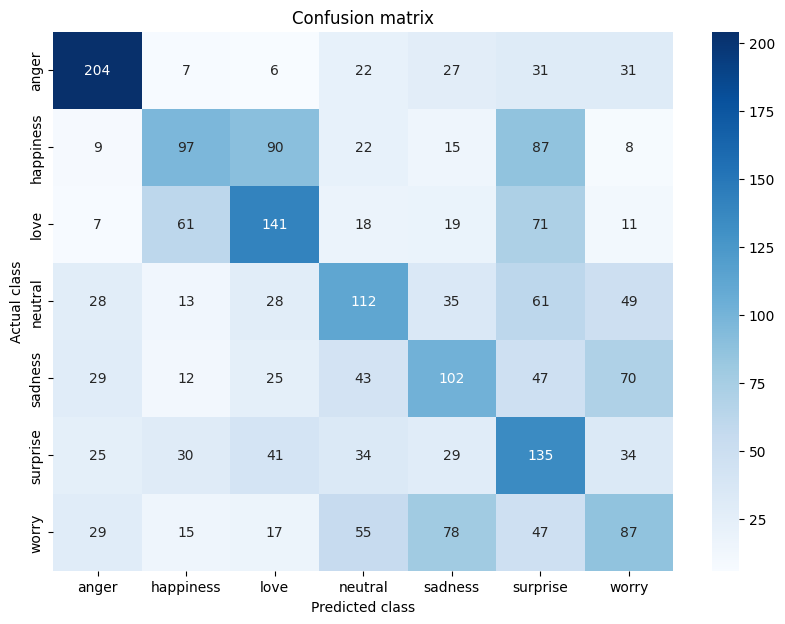

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# These lists will store the model's predictions and the true labels for the test set
true_labels = []
predicted_labels = []

# For each batch of training data...
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        # Forward pass
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask)
    logits = output.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Here we take the class with the higher score as the model's prediction
    predictions = np.argmax(logits, axis=1).flatten()

    # Extend the prediction and true label lists
    predicted_labels.extend(predictions)
    true_labels.extend(label_ids)

# Define the labels
labels = {
    0: 'anger',
    1: 'happiness',
    2: 'love',
    3: 'neutral',
    4: 'sadness',
    5: 'surprise',
    6: 'worry'
}

# Generate the classification report
print(classification_report(true_labels, predicted_labels, target_names=labels.values()))

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion matrix')
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()
